<a href="https://colab.research.google.com/github/Murcha1990/Raiffaizen_ML_summer2023/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_boosting/Raiff_SHAP_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интерпретация моделей с помощью SHAP

* [SHAP](https://habr.com/ru/post/428213/)


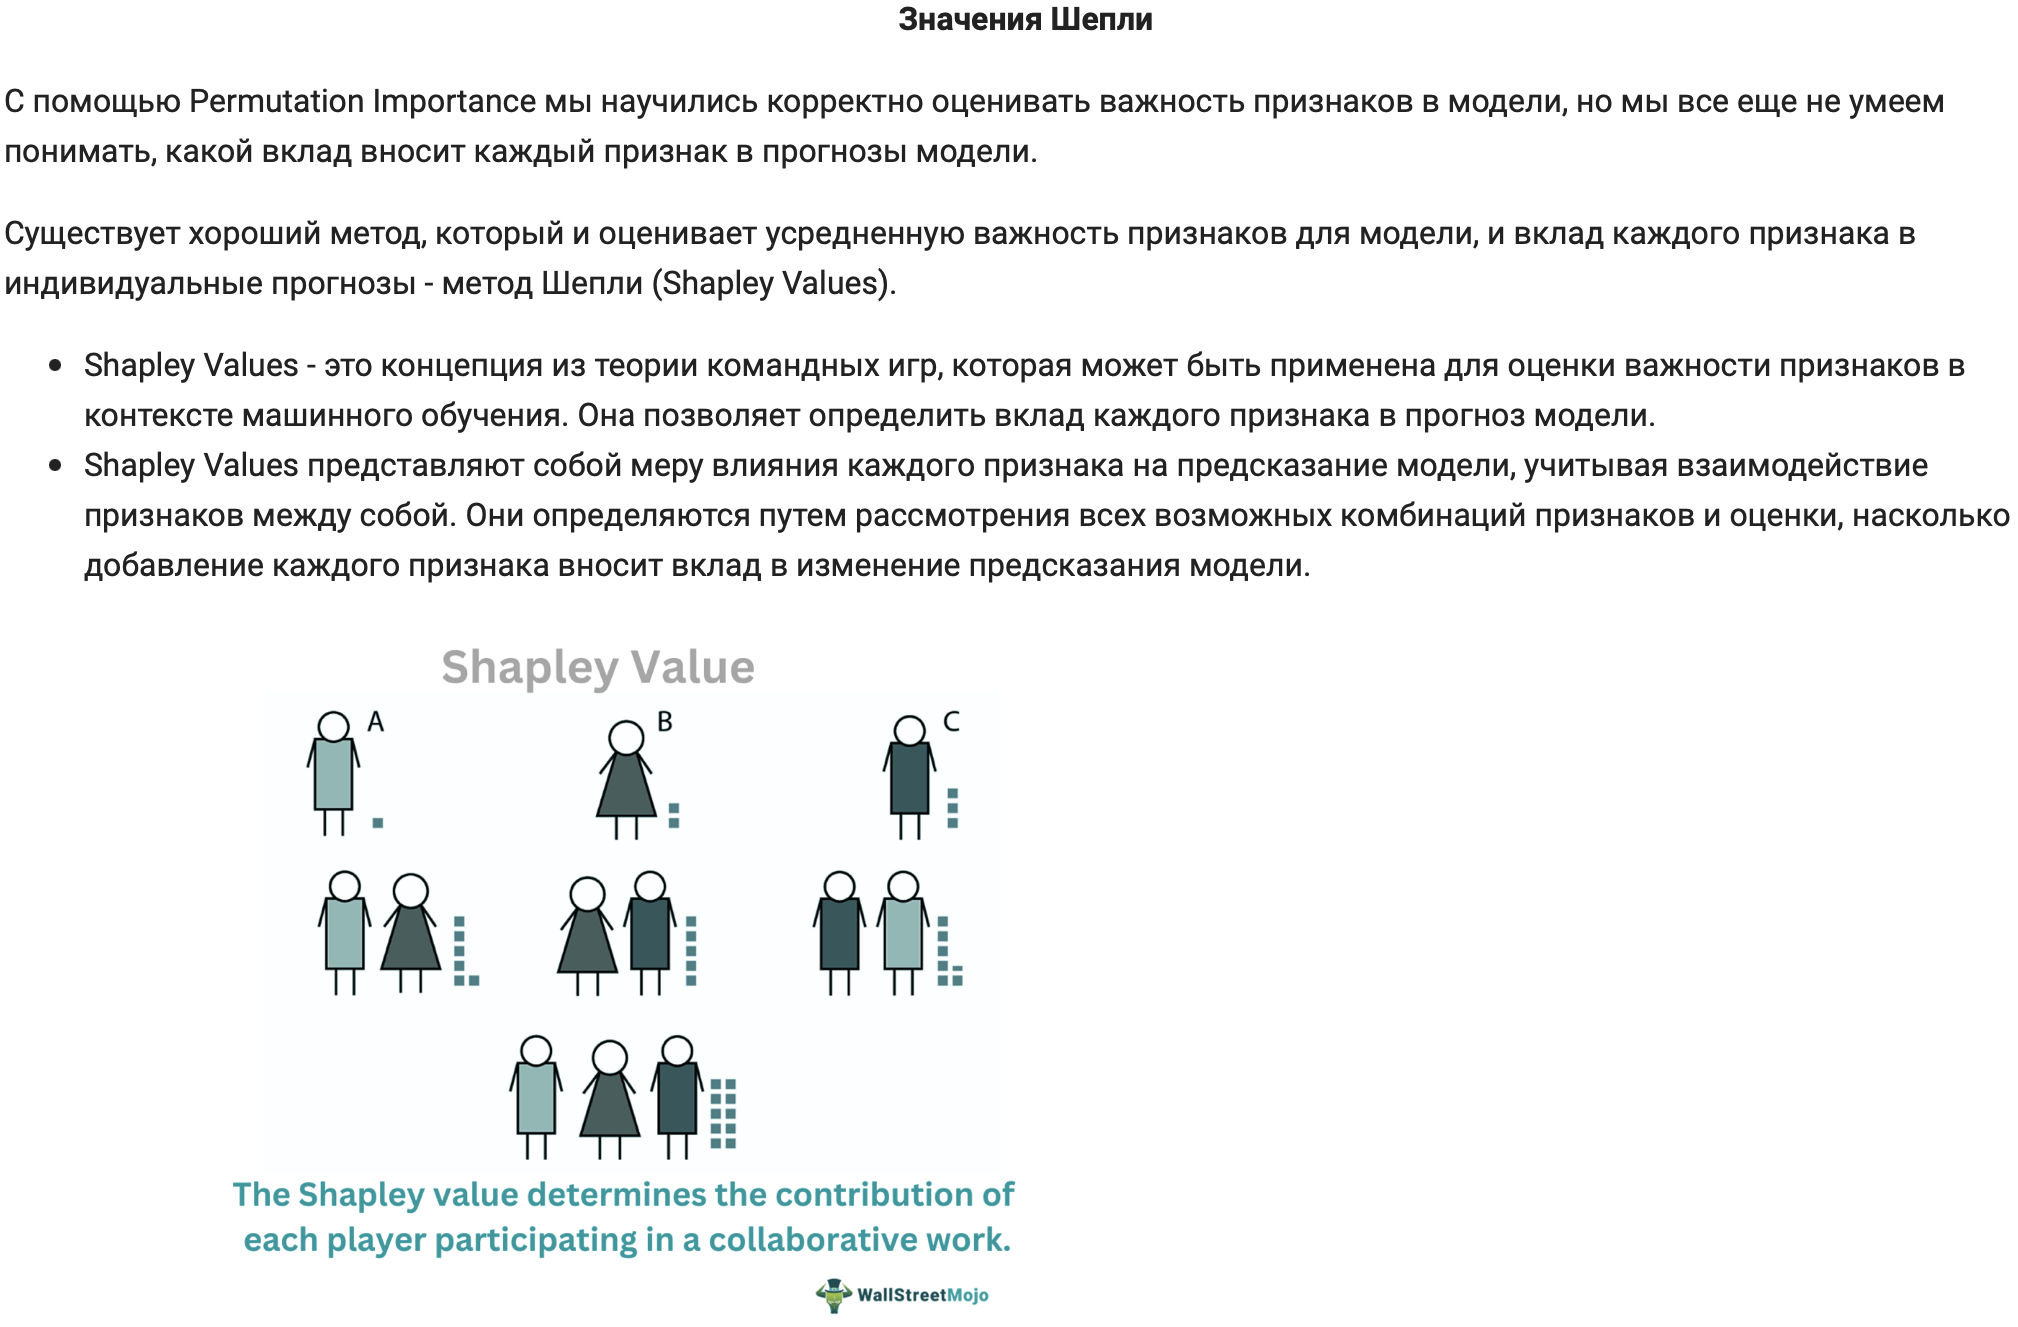

In [ ]:
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn import tree

### Загружаем данные

По имеющимся данным об энергоэффективности зданий в Нью-Йорке  построиит модель, которая прогнозирует количество баллов Energy Star Score для конкретного здания, и интерпретировать результаты для поиска факторов, влияющих на итоговый балл.

In [ ]:
# Read in data into dataframes
train_features = pd.read_csv("https://raw.githubusercontent.com/Murcha1990/Raiffaizen_ML_summer2023/main/Datasets/training_features.csv")
test_features = pd.read_csv("https://raw.githubusercontent.com/Murcha1990/Raiffaizen_ML_summer2023/main/Datasets/testing_features.csv")
train_labels = pd.read_csv("https://raw.githubusercontent.com/Murcha1990/Raiffaizen_ML_summer2023/main/Datasets/training_labels.csv")
test_labels = pd.read_csv("https://raw.githubusercontent.com/Murcha1990/Raiffaizen_ML_summer2023/main/Datasets/testing_labels.csv")

In [ ]:
train_features.head()

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Обучим модель

In [ ]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [ ]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
model = RandomForestRegressor()

model.fit(X, y)

RandomForestRegressor()

In [ ]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.5156


# Интерпретация модели

Встроенные в деревянные модели методы feature_importance_ показывают важность признаков для модели, но не показывают, какой вклад вносят признаки в ответ.

Для некоторых моделей даже нет базового готового решения, как посчитать важность (например, для KNN).

In [ ]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns),
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.596945
1,Weather Normalized Site Electricity Intensity ...,0.147814
2,Largest Property Use Type_Multifamily Housing,0.065048
3,Property Id,0.021150
4,DOF Gross Floor Area,0.018870
5,Year Built,0.017480
6,Order,0.016249
7,log_Direct GHG Emissions (Metric Tons CO2e),0.015937
8,Census Tract,0.012531
9,Largest Property Use Type_Non-Refrigerated War...,0.012044


Самые важные признаки:
* `Site EUI (kBtu/ft²)`
* Weather Normalized Site Electricity Intensity, `Weather Normalized Site Electricity Intensity (kWh/ft²)`

Нарисуем важность признаков.

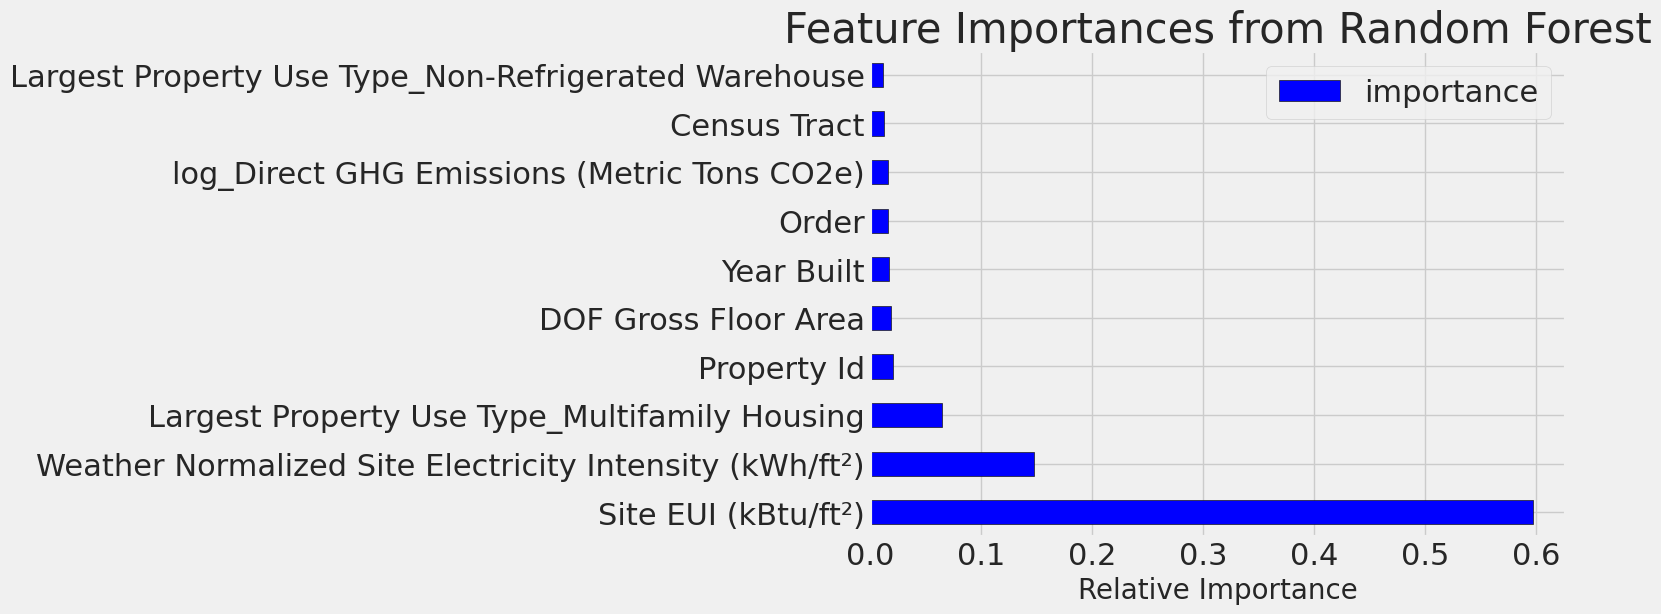

In [ ]:
figsize(8, 6)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance',
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Отбор признаков по feature importances

Попробуем выбросить признаки с маленькой важностью.


In [ ]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [ ]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.3377.


Видим, что для линейной модели всё же важны признаки, имеющие маленький вес по мнению бустинга.

In [ ]:
# Create the model with the same hyperparamters
model_reduced = RandomForestRegressor()

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.9894


Качество бустинга немного ухудшилось, поэтому для итоговой модели не стоит выкидывать признаки таким образом.

Но с целью интерпретируемости нас интересует максимально простая модель. Давайте дальше анализировать модель, обученную на 10 самых важных признаках.

## SHAP

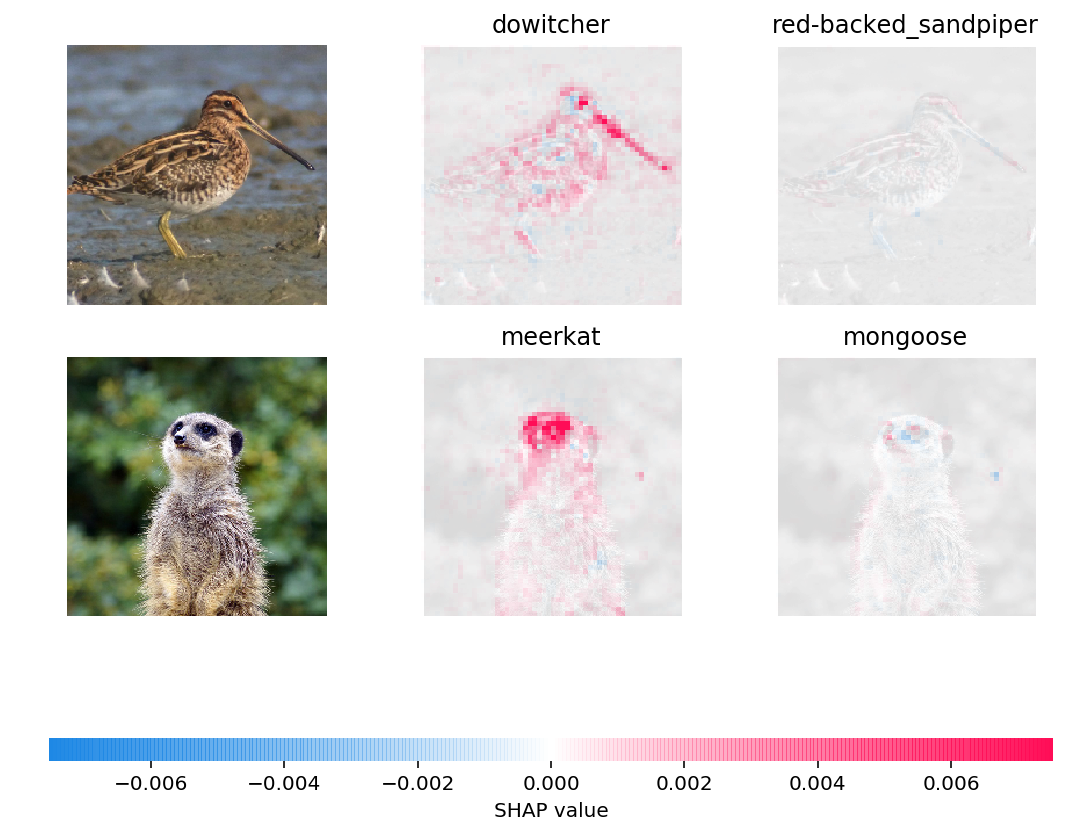

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
import shap
# shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
gb_explainer = shap.KernelExplainer(model_reduced.predict, X_test_reduced[1000:1100])
gb_shap_values = gb_explainer.shap_values(X_test_reduced[1000:1100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
shap.initjs()
shap.force_plot(gb_explainer.expected_value, gb_shap_values[23,:], X_test_reduced[23,:],
                feature_names = list(most_important_features))

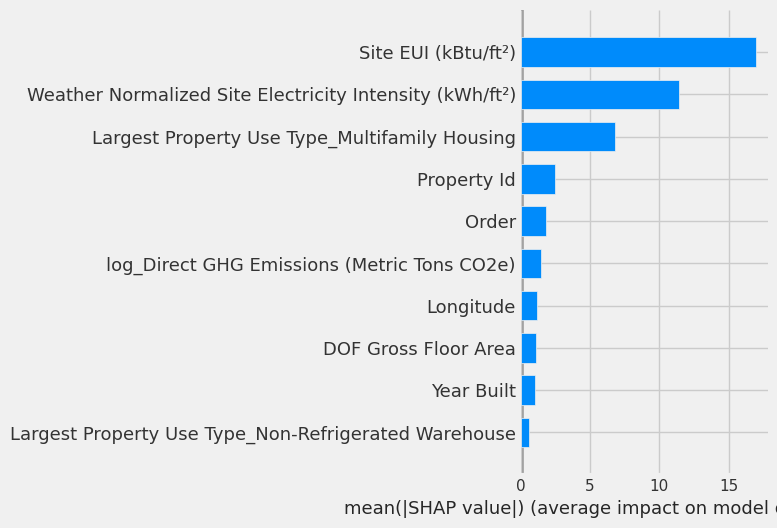

In [ ]:
shap.summary_plot(gb_shap_values, X_test_reduced[1000:1100], plot_type="bar", feature_names = list(most_important_features))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


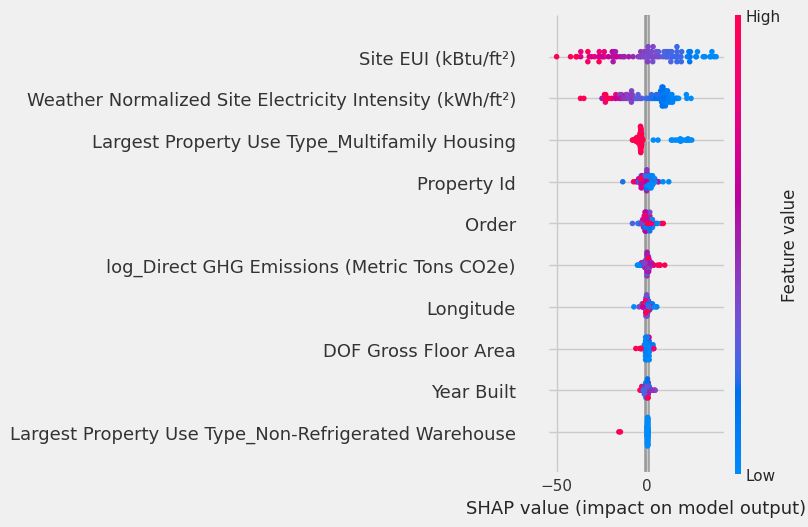

In [ ]:
shap.summary_plot(gb_shap_values, X_test_reduced[1000:1100], feature_names = list(most_important_features))

На гистограмме отображена следующая информация:

* **Feature importance:** признаки упорядочены по уменьшению важности

* **Impact:** Позиция точки по горизонтали показывает как влияет значение признака на более высокий или более низкий прогноз (более высокий прогноз - точка правее, более низкий - левее)

* **Original value:** цвет показывает значение признака (красный - большие значения признака, синий - маленькие)

* **Correlation:** высокие значения `Site EUI` имеют высокое и отрицательное влияние на `Energy Star Score` (target).

In [ ]:
shap.initjs()
shap.force_plot(gb_explainer.expected_value, gb_shap_values, X_test_reduced[1000:1100])